## Table of Contents

1. Introduction
1. Exploratory data analysis
1. Feature engineeing
1. Modeling and Prediction
1. Conclusion


## 1. Introduction

House Pricing Prediction has been a classic challenge, as the price of houses are usually dependent on many features. The goal of our study is to set up prediction models for Boston house prices, based on 80 given features.

Two data sets are given: the train data set consist of 1460 rows each representing a distinct house transaction, and 81 columns (1 SalePrice & 80 features),
and the test data set consist of 1459 rows, and 80 columns (features).

Our study follows the process: exploratory data analysis - feature engineering - prediction model setting. Finally 7 models are used and ensembles. The result turns out that:

In [1]:
# Import all the dependencies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, PowerTransformer
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import VarianceThreshold


## 2. Exploratory data analysis

### 2.1 Load the data

In [2]:
# Load data from csv files
train_data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test_data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

In [3]:
combined_data = pd.concat([train_data, test_data], axis=0)
combined_data['Label'] =  combined_data['SalePrice'].isnull()
mapping = {False:'Tain Data',True:'Test Data' }
combined_data['Label'] = combined_data['Label'].map(mapping)

### 2.2 Train Data Exploration

For both train and test data, we explored the items as below:
- first 5 rows
- data shape
- general data information
- data type
- null value

#### 2.2.1 First Five Records - Train Data

In [4]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### 2.2.2 Data Shape - Train Data

In [5]:
print(train_data.shape)

(1460, 81)


#### 2.2.3 Data Information - Trian Data

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

#### 2.2.4 Data Type - Train Data

In [7]:
s1 = train_data.dtypes
s1.groupby(s1).count()

int64      35
float64     3
object     43
dtype: int64

#### 2.2.5 Null Value - Train Data

In [8]:
train_data.isnull().sum().sort_values(ascending = False).head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
Id                 0
dtype: int64

### 2.3 Test Data Exploration

#### 2.3.1 First Five Records - Test Data

In [9]:
test_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


#### 2.3.2 Data Type - Test data

In [10]:
print(test_data.shape)

(1459, 80)


#### 2.3.3 Data Information - Test Data

In [11]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

#### 2.3.4 Data Type - Test Data

In [12]:
s2 = test_data.dtypes
s2.groupby(s2).count()

int64      26
float64    11
object     43
dtype: int64

#### 2.3.5 Null Data - Test Data

In [13]:
test_data.isnull().sum().sort_values(ascending = False).head(33)

PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
LotFrontage      227
GarageYrBlt       78
GarageQual        78
GarageFinish      78
GarageCond        78
GarageType        76
BsmtCond          45
BsmtQual          44
BsmtExposure      44
BsmtFinType1      42
BsmtFinType2      42
MasVnrType        16
MasVnrArea        15
MSZoning           4
BsmtHalfBath       2
Utilities          2
Functional         2
BsmtFullBath       2
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
KitchenQual        1
TotalBsmtSF        1
Exterior2nd        1
GarageCars         1
Exterior1st        1
GarageArea         1
SaleType           1
dtype: int64

### 2.4 Train Data & Test Data Comnparison

After exploration, we noticed that data types seem not match between train and test data, so we want to compare the differences.
In this part, we mainly compared features below between train and test data:
- Data Types
- Null Values
- Data Distribution

#### 2.4.1 Data Type Comparison

In [14]:
s1_train = s1.drop('SalePrice')
s1_train.compare(s2)

,self,other
BsmtFinSF1,int64,float64
BsmtFinSF2,int64,float64
BsmtUnfSF,int64,float64
TotalBsmtSF,int64,float64
BsmtFullBath,int64,float64
BsmtHalfBath,int64,float64
GarageCars,int64,float64
GarageArea,int64,float64


In [15]:
test_data['GarageArea'].head(5)

0    730.0
1    312.0
2    482.0
3    470.0
4    506.0
Name: GarageArea, dtype: float64

The inconsistent data types are int64&float64 and not considered a problem.

#### 2.4.2 Null Value Comparison

In [16]:
null_train = train_data.isnull().sum()
null_test = test_data.isnull().sum()
null_train = null_train.drop('SalePrice')
null_train.compare(null_test).sort_values(['self','other'], ascending= [False,False])

,self,other
PoolQC,1453.0,1456.0
MiscFeature,1406.0,1408.0
Alley,1369.0,1352.0
Fence,1179.0,1169.0
FireplaceQu,690.0,730.0
LotFrontage,259.0,227.0
GarageYrBlt,81.0,78.0
GarageFinish,81.0,78.0
GarageQual,81.0,78.0
GarageCond,81.0,78.0


We noticed PoolQC, MiscFeature, Alley, Fence are the features with most missing values, we will consider to drop a few such features later.

#### 2.4.3 Distribution Comparison - Continous Variables

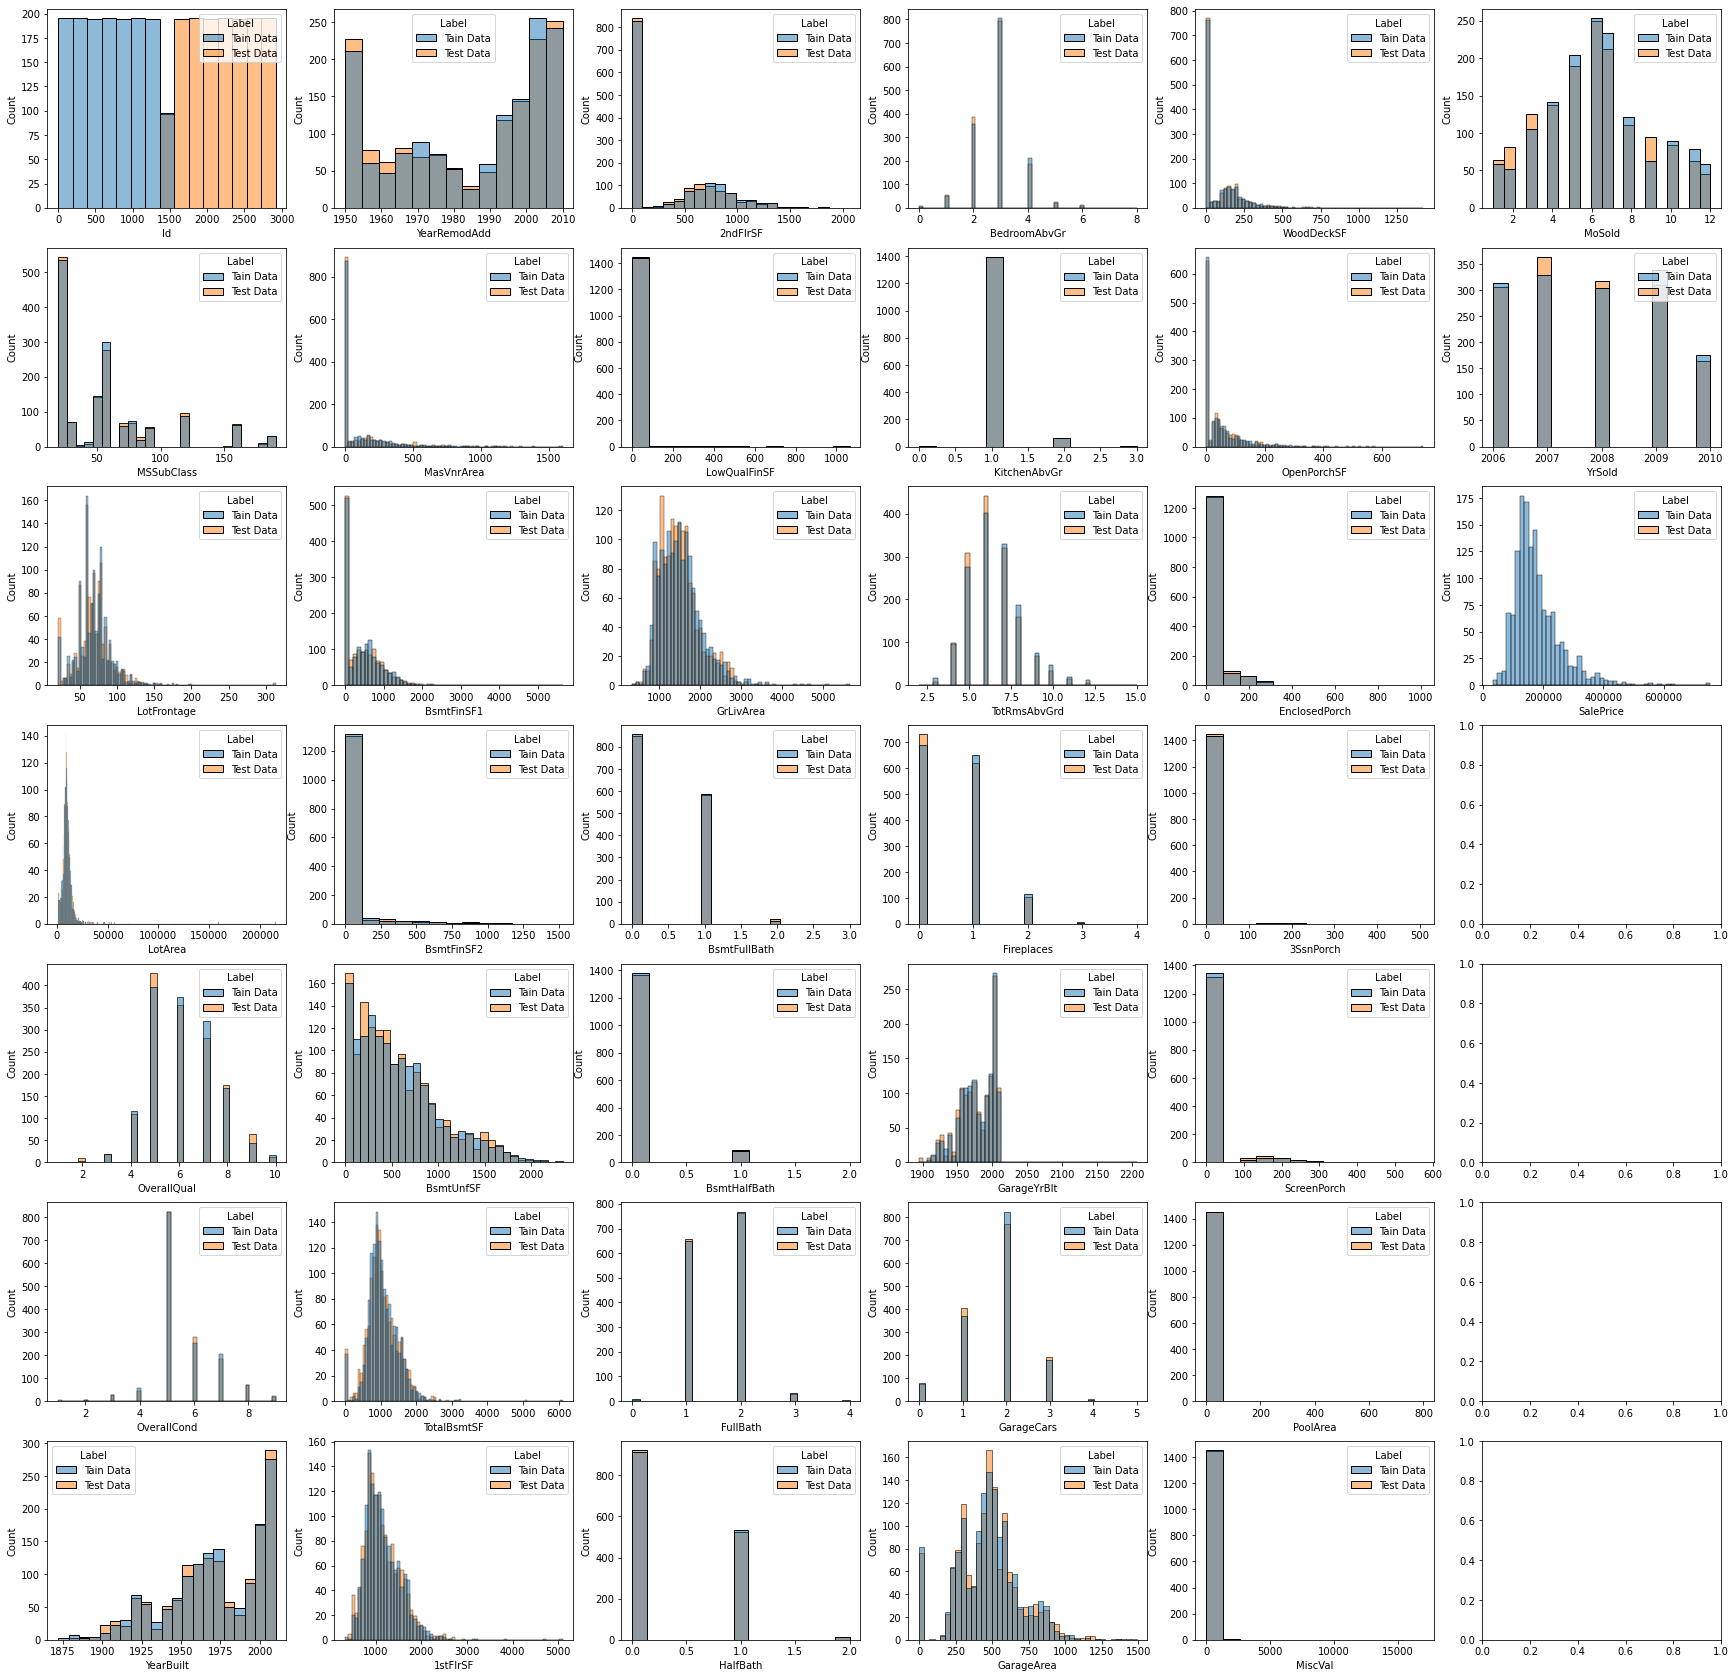

In [17]:
con_var = s1[s1.values != 'object'].index
f, axes = plt.subplots(7,6 , figsize=(30, 30), sharex=False)
for i, feature in enumerate(con_var):
    sns.histplot(data=combined_data, x = feature, hue="Label",ax=axes[i%7, i//7])

The distribution above shows that:
- The distribution of train data and test data are similar for most continous features;
- Some features can be reclassified as 'Categorical', such as 'MSSubClass';
- Some features are dominated by 0/null (eg:PoolArea), thus we can consider to drop.

Then we also want to see the linearity between all features and the response variable (saleprice)

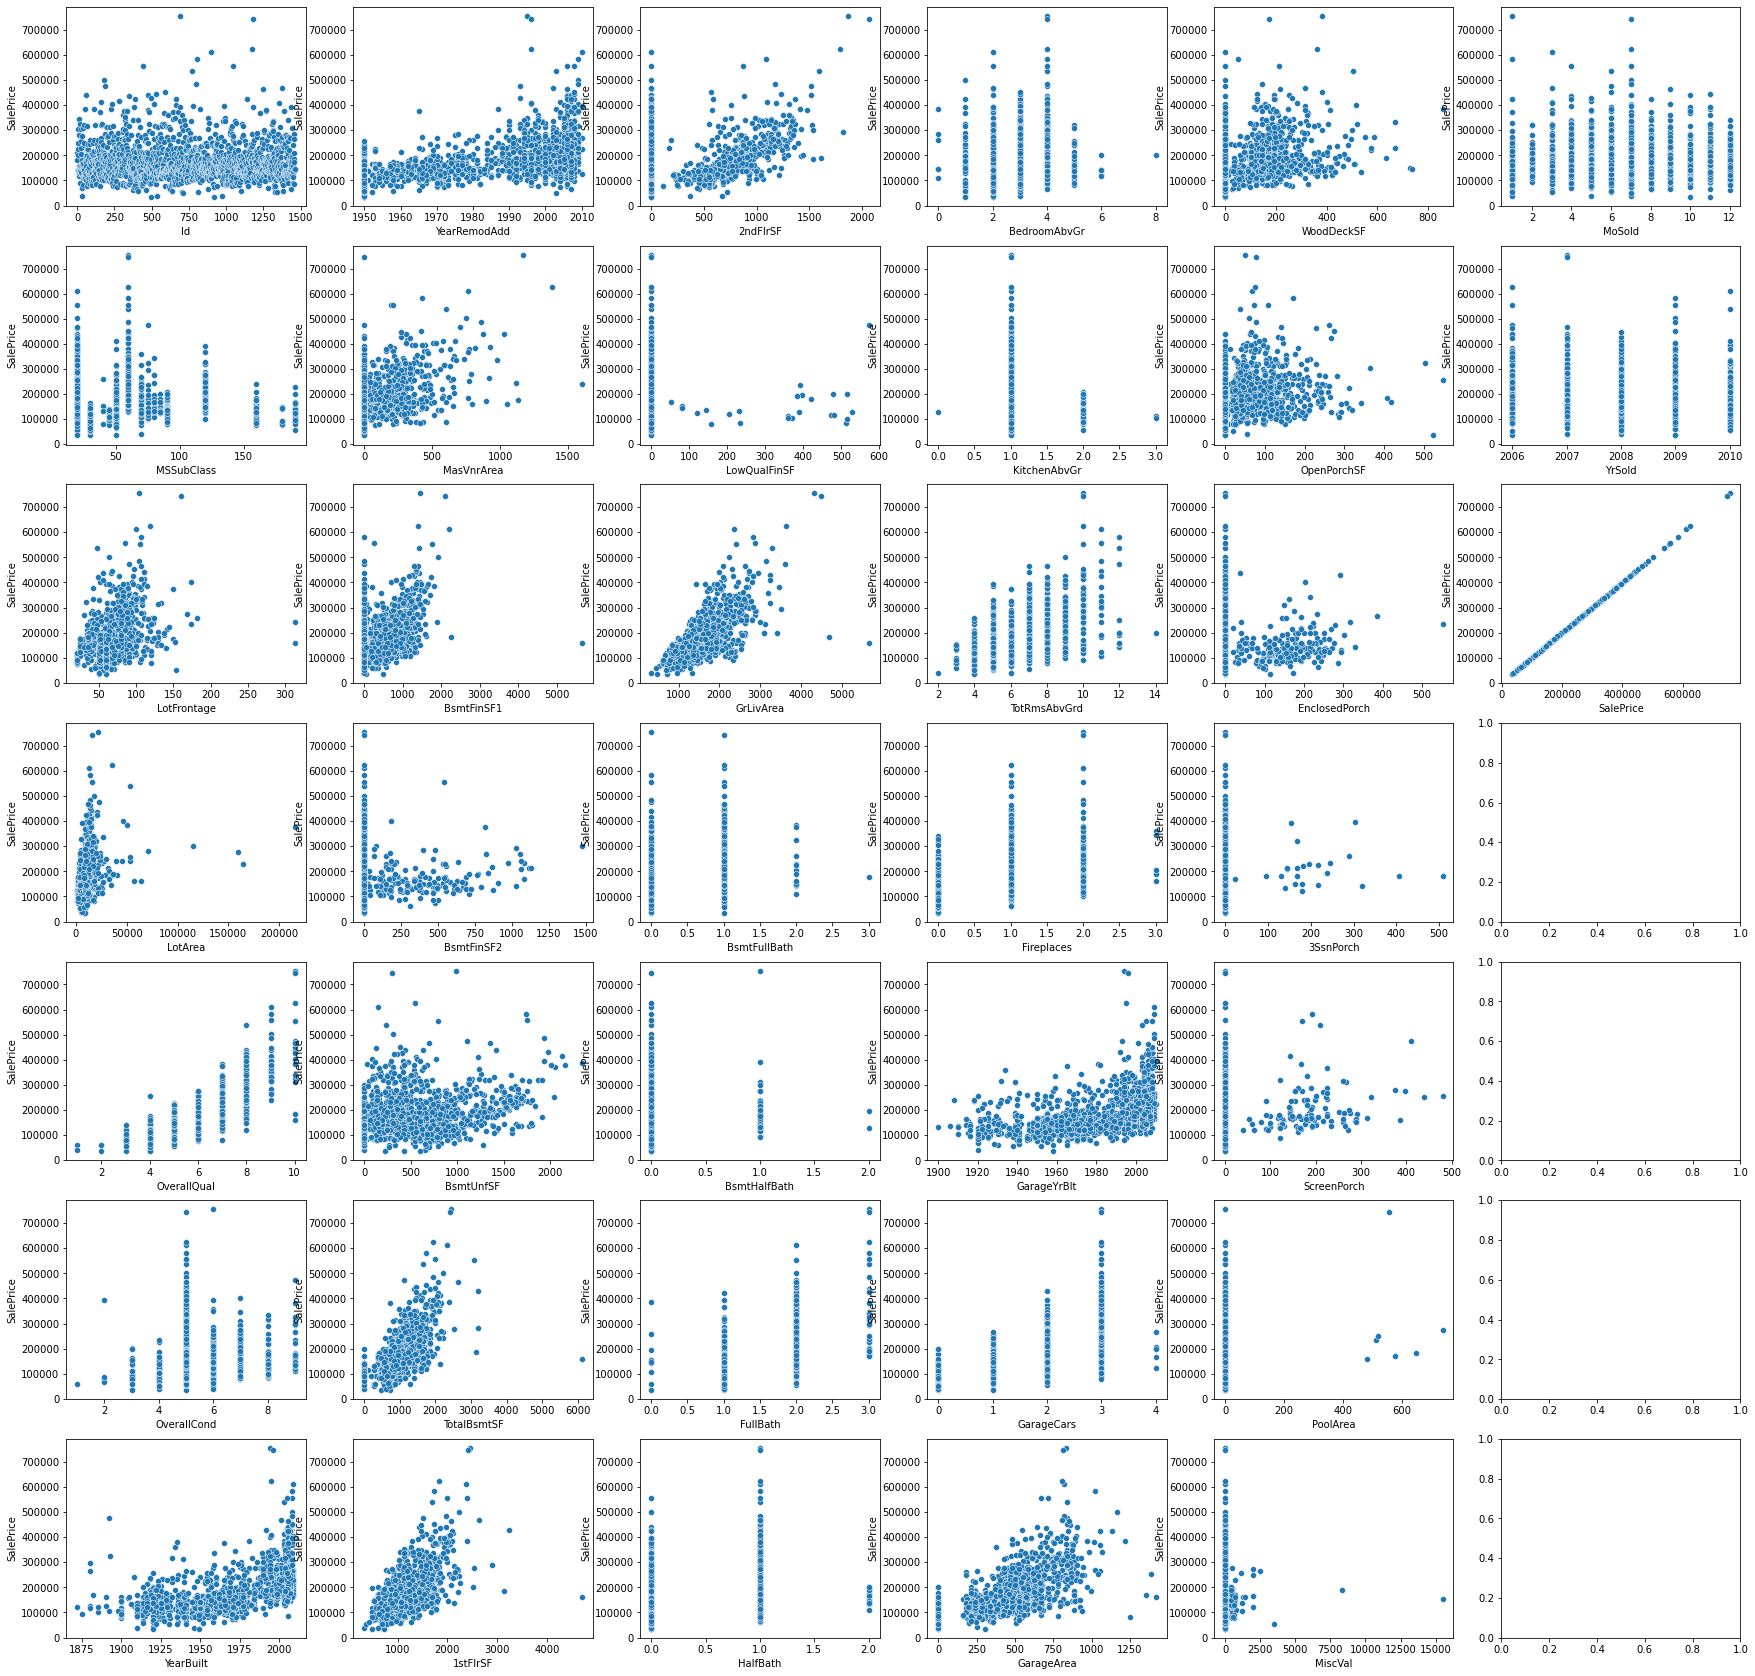

In [18]:
f, axes = plt.subplots(7,6 , figsize=(30, 30), sharex=False)
for i, feature in enumerate(con_var):
    sns.scatterplot(data=train_data, x = feature, y= "SalePrice",ax=axes[i%7, i//7])

Here, we can see that some relations seem positive but not quite linear:
- 'SalePrice' VS.'BsmtUnfSF', 
- 'SalePrice' VS.'LotFrontage', 
- 'SalePrice' VS.'LotArea', 
- 'SalePrice' VS.'1stFlrSF', 
- 'SalePrice' VS.'GrLivArea',
- 'SalePrice' VS.'TotalBsmtSF', 
- 'SalePrice' VS.'GarageArea',
So we will consider transform such features into log forms.

#### 2.4.4 Distribution Comparison - Catagorical Variables

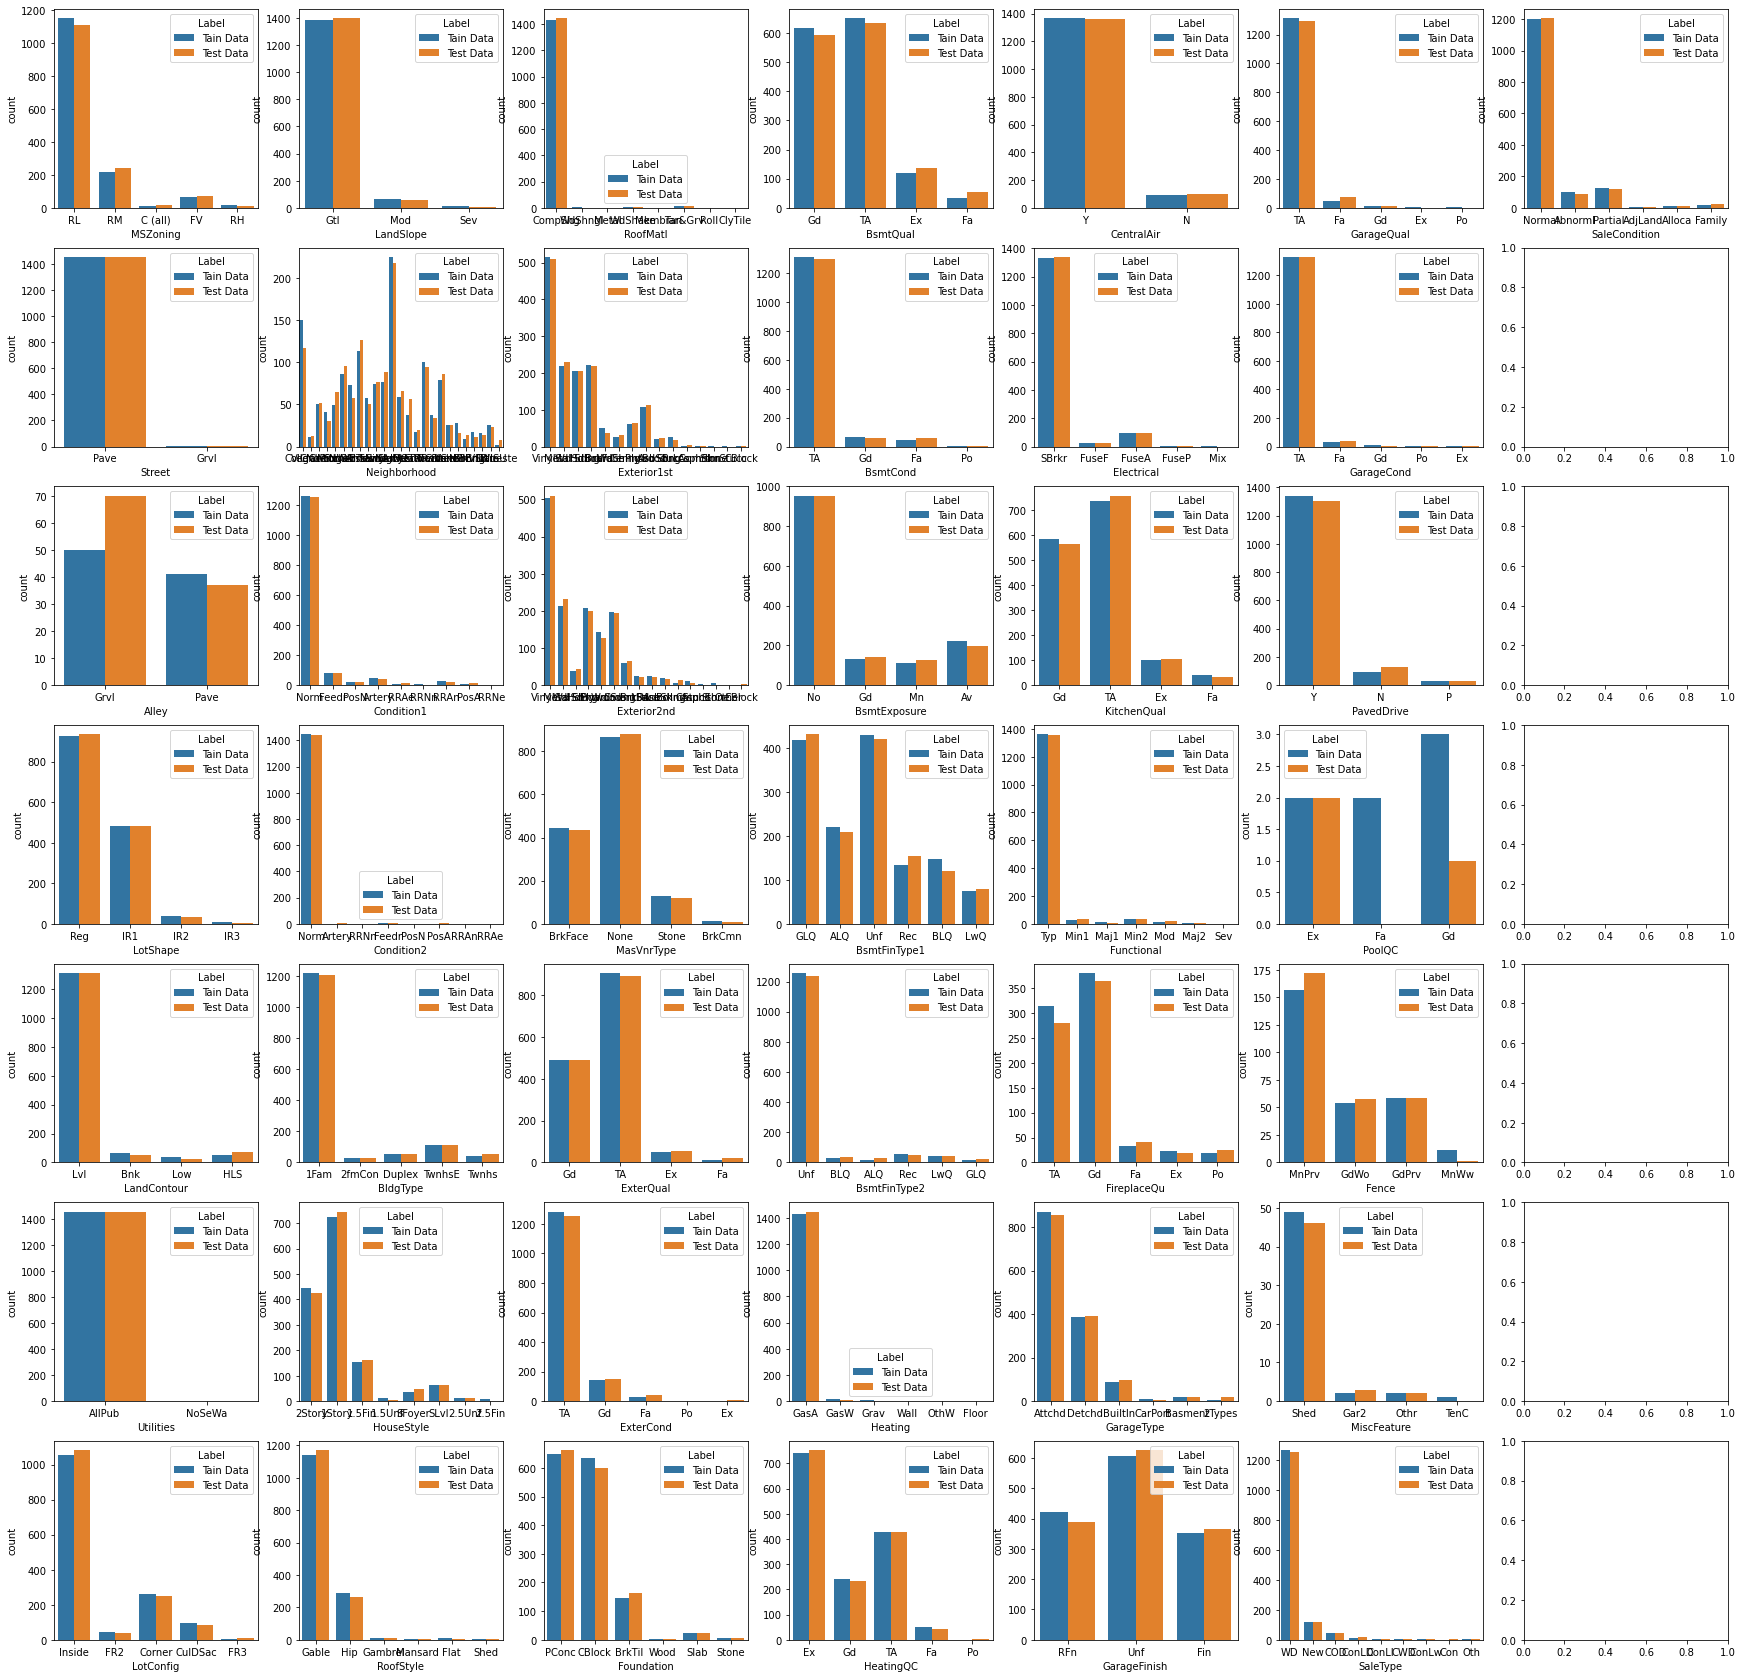

In [19]:
cat_var = s1[s1.values == 'object'].index
f, axes = plt.subplots(7,7 , figsize=(30, 30), sharex=False)
for i, feature in enumerate(cat_var):
    sns.countplot(data = combined_data, x = feature, hue="Label",ax=axes[i%7, i//7])

The comparison of the categorical variables showed that:
- Train data and test data distributions are similar for most features
- Some features have dominant items, we can consider to combine some minor items into a group, such as
    - 'Fa' & 'Po' in 'HeatingQC', 'FireplaceQu', 'GarageQual' and 'GarageCond'

We also want to confirm that the items we want to combine has similar prices.

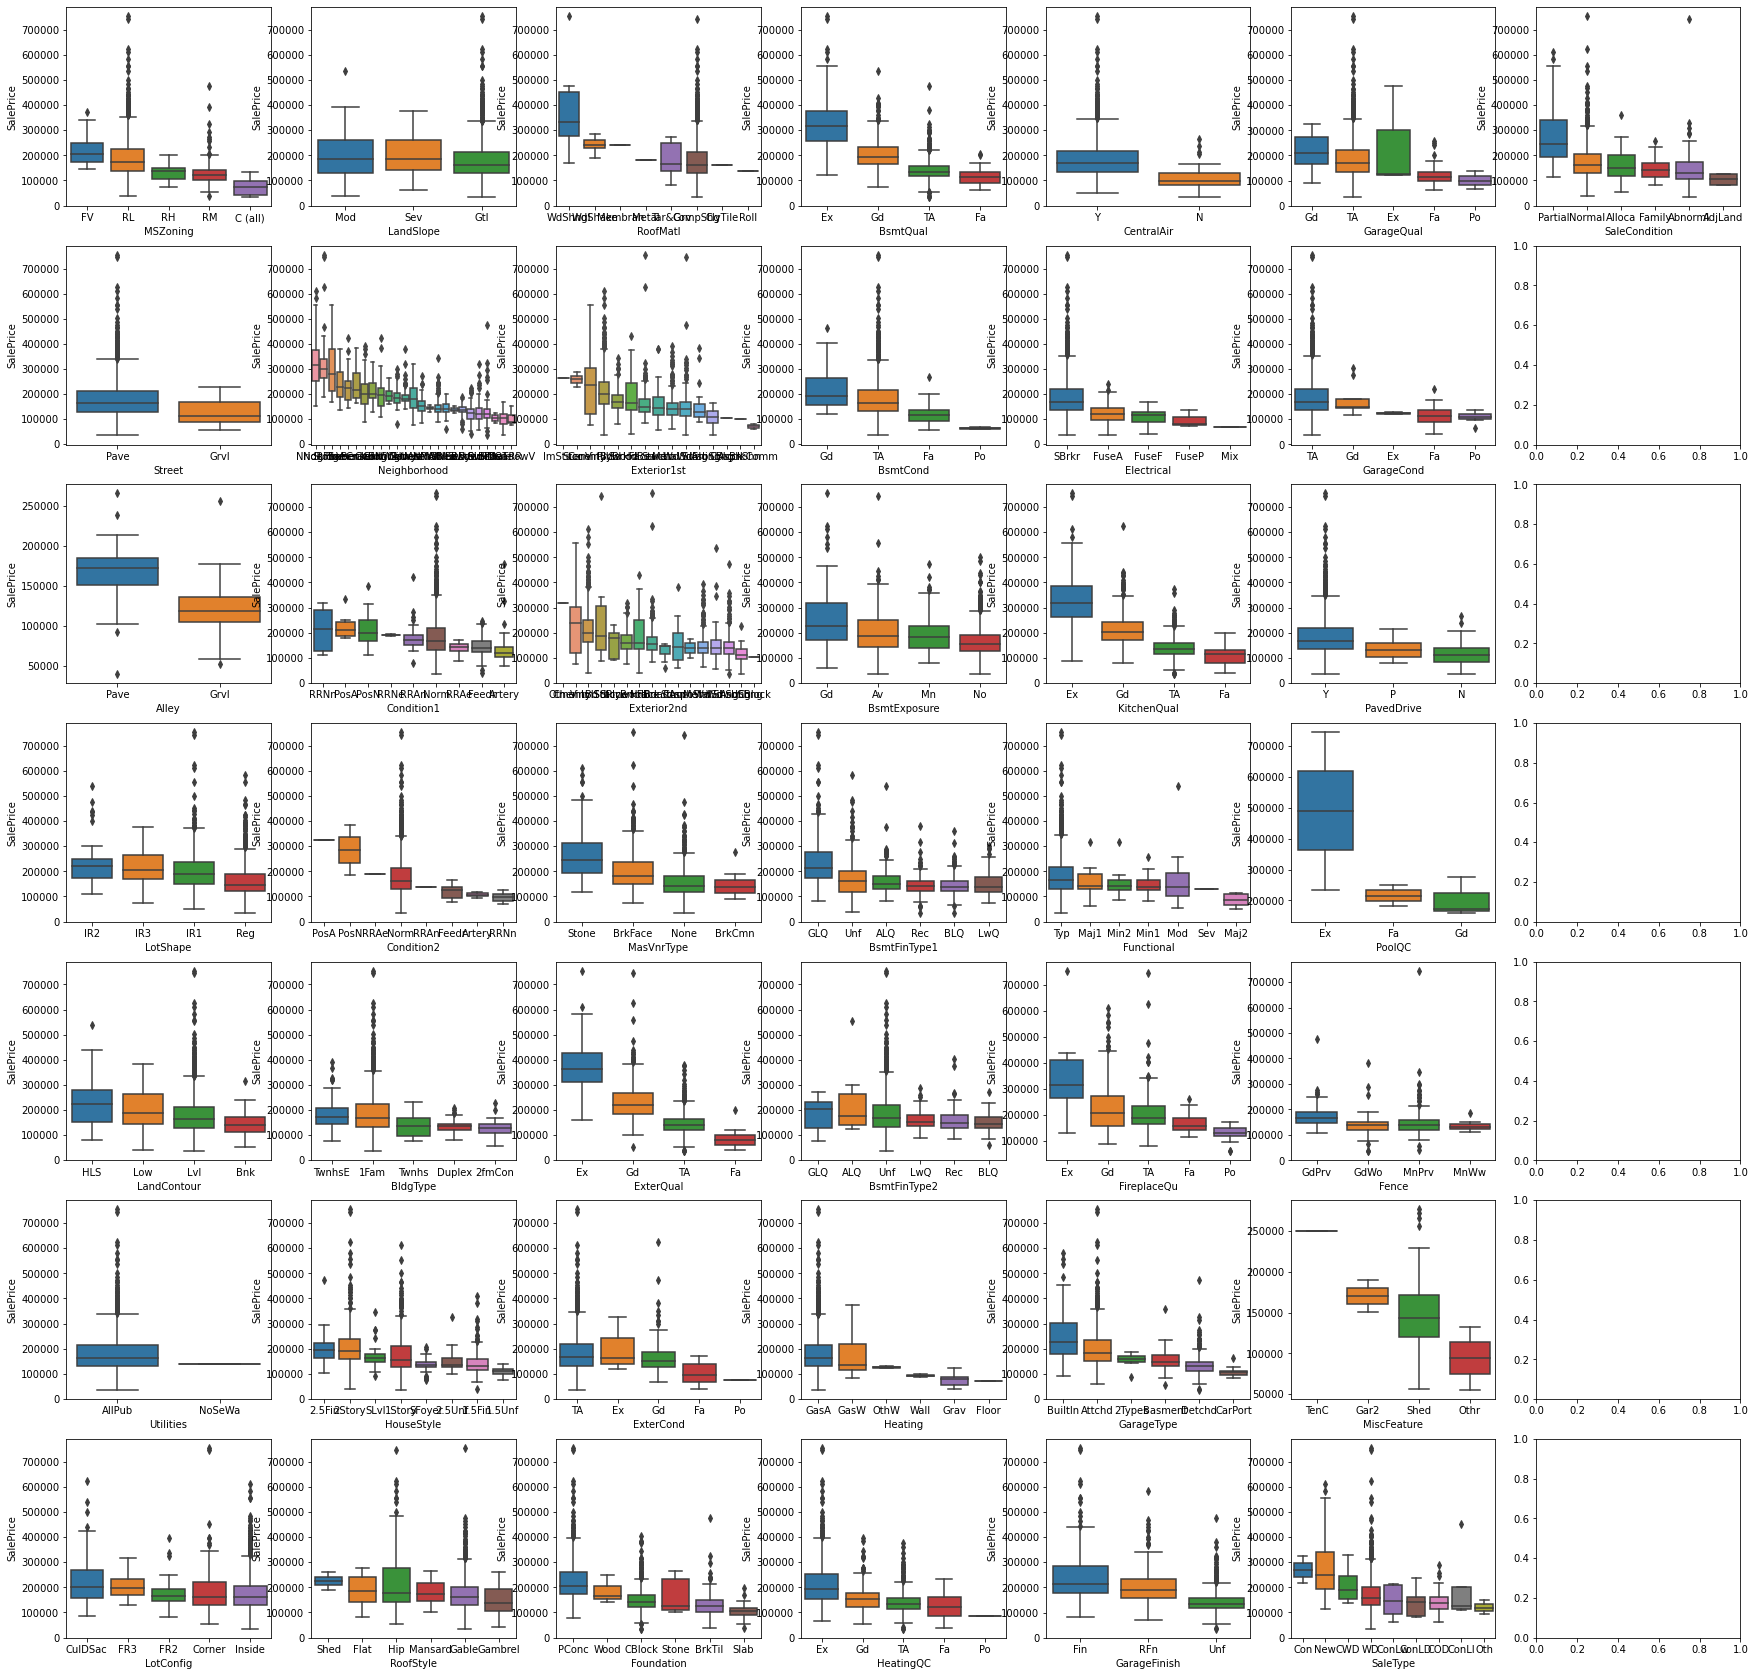

In [20]:
f, axes = plt.subplots(7,7 , figsize=(30, 30), sharex=False)
for i, feature in enumerate(cat_var):
    sort_list = sorted(train_data.groupby(feature)['SalePrice'].median().items(), key= lambda x:x[1], reverse = True)
    order_list = [x[0] for x in sort_list ]
    sns.boxplot(data = train_data, x = feature, y = 'SalePrice', order=order_list, ax=axes[i%7, i//7])
plt.show()

Here, we could see that sale prices for 'Fa' & 'Po' in 'HeatingQC', 'FireplaceQu', 'GarageQual' and 'GarageCond' are similar, so we may consider go ahead and combine the items.

### 2.5 Data Correlation

<AxesSubplot:>

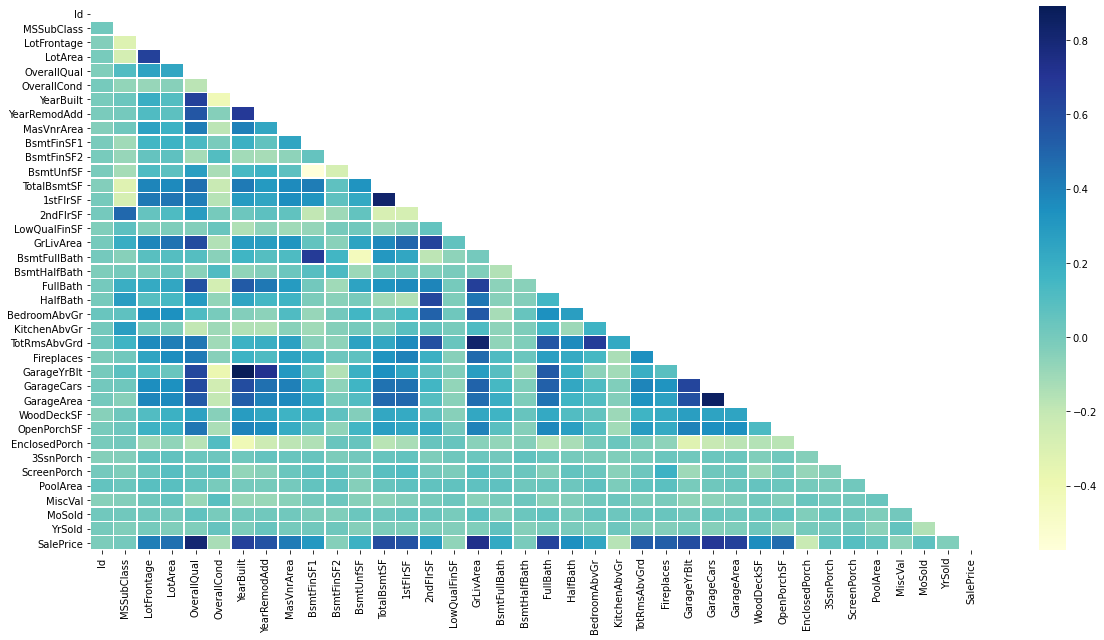

In [21]:
con_data = train_data.copy()
for col in cat_var:
    con_data = con_data.drop(col, axis = 1)

training_corr = con_data.corr(method='spearman')
mask = np.zeros_like(training_corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(20,10))
sns.heatmap(training_corr, mask=mask, cmap="YlGnBu", linewidths=.5)

Here we see that 'OverallQual', 'GrlivArea', 'GarageCars' are highly correlated to SalePrice.

In [22]:
# Top 10 correlated features vs. SalePrice
correlations = con_data.corr(method='spearman')['SalePrice'].sort_values(ascending=False)
correlations_abs = correlations.abs()
print(correlations_abs.head(11))

SalePrice       1.000000
OverallQual     0.809829
GrLivArea       0.731310
GarageCars      0.690711
YearBuilt       0.652682
GarageArea      0.649379
FullBath        0.635957
TotalBsmtSF     0.602725
GarageYrBlt     0.593788
1stFlrSF        0.575408
YearRemodAdd    0.571159
Name: SalePrice, dtype: float64


## 3. Feature engineeing


In [23]:
def pre_process(train_data, test_data, fillna_dict = {}, drop_list = [], convert_list=[], log_list=[], regroup_dict={}):
    combined_data = pd.concat([train_data, test_data], ignore_index=True, axis=0)
    
    # Step 1: Fill missing values
    for col, fill_value in fillna_dict.items():
        combined_data[col] = combined_data[col].fillna(value=fill_value)
        
    # Step 2: Drop columns
    combined_data.drop(columns=drop_list, inplace=True, errors='ignore')
    
    # Step 3: Convert "numerical" feature to categorical
    for col in convert_list:
        combined_data[col] = combined_data[col].astype('str')
        
    # Step 4: Apply PowerTransformer to columns
    for col in log_list:
        log = PowerTransformer()
        log.fit(train_data[[col]]) # TODO: fit with combined_data to avoid overfitting with training data?
        combined_data[col] = log.transform(combined_data[[col]])
        
    # Step 5: Regroup features
    for col, regroup_value in regroup_dict.items():
        mask = combined_data[col].isin(regroup_value)
        combined_data[col][mask] = 'Other'
        
    # Step 6: Drop categorical features with an absolute dominatining value
#     for i in combined_data.columns:
#         if combined_data[i].dtype != 'object':
#             continue
#         counts = combined_data[i].value_counts()
#         zeros = counts.iloc[0]
#         if zeros / len(combined_data) > 0.995:
#             print(f'Feature {combined_data[i].name} value {counts.index[0]} is dominating with percentage {zeros / len(combined_data)}, dropping the feature')
#             combined_data.drop(columns=combined_data[i].name, inplace=True, errors='ignore')
    
    # Step 7: Add features
#     combined_data['Total_Home_Quality'] = combined_data['OverallQual'] + combined_data['OverallCond']

#     combined_data['Total_Bathrooms'] = (combined_data['FullBath'] + (0.5 * combined_data['HalfBath']) +
#                                combined_data['BsmtFullBath'] + (0.5 * combined_data['BsmtHalfBath']))

#     combined_data["HighQualSF"] = combined_data["1stFlrSF"] + combined_data["2ndFlrSF"]

#     combined_data['Total_sqr_footage'] = (combined_data['BsmtFinSF1'] + combined_data['BsmtFinSF2'] +
#                                  combined_data['1stFlrSF'] + combined_data['2ndFlrSF'])
    
    # Step -1: Generate one-hot dummy columns
    combined_data = pd.get_dummies(combined_data).reset_index(drop=True)
    
    new_train_data = combined_data.iloc[:len(train_data), :]
    new_test_data = combined_data.iloc[len(train_data):, :]
    X_train = new_train_data.drop('SalePrice', axis=1)
    y_train = np.log1p(new_train_data['SalePrice'].values.ravel())
    X_test = new_test_data.drop('SalePrice', axis=1)
    return X_train, y_train, X_test

In [24]:
fillna_dict = {
    'Alley': 'NA',
    'PoolQC': 'NA',
    'LotFrontage': train_data['LotFrontage'].mean(),
    'MasVnrArea': 0.0,
    'GarageYrBlt': 0.0,
    'BsmtFinSF1': 0.0,
    'BsmtFinSF2': 0.0,
    'BsmtUnfSF': 0.0,
    'TotalBsmtSF': 0.0,
    'BsmtFullBath': 0.0,
    'BsmtHalfBath': 0.0,
    'GarageCars': 0.0,
    'GarageArea': 0.0,
    'MiscFeature': 'NA',
    'Fence':'NA',
    'FireplaceQu': 'NA',
    'GarageFinish': 'NA',
    'GarageQual': 'NA',
    'GarageCond': 'NA',
    'GarageType': 'NA',
    'BsmtCond': 'NA',
    'BsmtQual': 'NA',
    'BsmtExposure':'NA',
    'BsmtFinType1':'NA',
    'BsmtFinType2':'NA',
    'MasVnrType': 'None',
    'MSZoning': train_data['MSZoning'].mode()[0]
}

drop_list = ['Id']

convert_to_str_list = ['MSSubClass']

log_list = [
    'BsmtUnfSF', 'LotFrontage', 'LotArea', '1stFlrSF', 'GrLivArea',
    'TotalBsmtSF', 'GarageArea',
]

regroup_dict = {
#     'LotConfig': ['FR2','FR3'],
#     'LandSlope':['Mod','Sev'],
#     'BldgType':['2FmCon','Duplex'],
#     'RoofStyle':['Mansard','Flat','Gambrel'],
#     'Electrical':['FuseF','FuseP','FuseA','Mix'],
#     'SaleCondition':['Abnorml','AdjLand','Alloca','Family'],
#     'BsmtExposure':['Min','Av'],
#     'Functional':['Min1','Maj1','Min2','Mod','Maj2','Sev'],
#     'LotShape':['IR2','IR3'],
    'HeatingQC':['Fa','Po'],
    'FireplaceQu':['Fa','Po'],
    'GarageQual':['Fa','Po'],
    'GarageCond':['Fa','Po'],
}

X, y, X_test = pre_process(train_data, test_data,
                           fillna_dict=fillna_dict,
                           drop_list=drop_list,
                           convert_list=convert_to_str_list,
                           log_list=log_list,
                           regroup_dict=regroup_dict,
                          )

print(X.shape)

pre_precessing_pipeline = make_pipeline(RobustScaler(), 
                                        # VarianceThreshold(0.001),
                                       )

X = pre_precessing_pipeline.fit_transform(X)
X_test = pre_precessing_pipeline.transform(X_test)

print(X.shape)
print(X_test.shape)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(1460, 313)
(1460, 313)
(1459, 313)


## 4. Modeling and Prediction

In this section, we will fit the model with the data, tune the hyperparameters of them, and make prediction for the testing data.

We selected the following regressor models:
- [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)
- [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)
- [Elastic Net](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html)
- [SVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)
- [Random Forest Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
- [Gradient Boosting Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html)
- [Stacking Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingRegressor.html) with the other models

Regarding hyperparameter tuning, we preferred the searching algorithm of [Optuna](https://github.com/optuna/optuna).

In [25]:
RANDOM_SEED = 42

# 10-fold CV
kfolds = KFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)

In [26]:
def tune(objective):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score} \nOptimized parameters: {params}")
    return params

In [27]:
def ridge_objective(trial):

    _alpha = trial.suggest_float("alpha", 0.1, 20)

    ridge = Ridge(alpha=_alpha, random_state=RANDOM_SEED)

    score = cross_val_score(
        ridge, X, y, cv=kfolds, scoring="neg_root_mean_squared_error"
    ).mean()
    return score

# Best score: -0.12599963936207256 
# ridge_params = tune(ridge_objective)
ridge_params = {'alpha': 7.491061624529043}

In [28]:
ridge = Ridge(**ridge_params, random_state=RANDOM_SEED)
ridge.fit(X, y)

Ridge(alpha=7.491061624529043, random_state=42)

In [29]:
def lasso_objective(trial):

    _alpha = trial.suggest_float("alpha", 0.0001, 1)

    lasso = Lasso(alpha=_alpha, random_state=RANDOM_SEED)

    score = cross_val_score(
        lasso, X, y, cv=kfolds, scoring="neg_root_mean_squared_error"
    ).mean()
    return score

# Best score:-0.1237148073006272
# lasso_params = tune(lasso_objective)
lasso_params = {'alpha': 0.00041398687418613947}

In [30]:
lasso = Lasso(**lasso_params, random_state=RANDOM_SEED)
lasso.fit(X, y)

Lasso(alpha=0.00041398687418613947, random_state=42)

In [31]:
def elasticnet_objective(trial):

    _alpha = trial.suggest_float("alpha", 0.0001, 1)
    _l1_ratio = trial.suggest_float("l1_ratio", 0.01, 1)

    elastic = ElasticNet(alpha=_alpha, l1_ratio=_l1_ratio, random_state=RANDOM_SEED)

    score = cross_val_score(
        elastic, X, y, cv=kfolds, scoring="neg_root_mean_squared_error"
    ).mean()
    return score

# Best score:-0.12399332824933833
# elasticnet_params = tune(elasticnet_objective)
elasticnet_params = {'alpha': 0.00048679709811971084, 'l1_ratio': 0.5791344072946181}

In [32]:
elasticnet = ElasticNet(**elasticnet_params, random_state=RANDOM_SEED)
elasticnet.fit(X, y)

ElasticNet(alpha=0.00048679709811971084, l1_ratio=0.5791344072946181,
           random_state=42)

In [33]:
def svr_objective(trial):

    _C = trial.suggest_float("C", 0.01, 1)
    _epsilon = trial.suggest_float("epsilon", 0.01, 0.1)
#     _kernel = trial.suggest_categorical("kernel", ['linear', 'poly', 'rbf', 'sigmoid'])
    _coef0 = trial.suggest_float("coef0", 0.01, 1)

    svr = SVR(C=_C, epsilon=_epsilon, kernel='poly')

    score = cross_val_score(
        svr, X, y, cv=kfolds, scoring="neg_root_mean_squared_error"
    ).mean()
    return score


# Best score: -0.5497646905509261
# svr_params = tune(svr_objective)
svr_params = {'C': 0.010017541167933656, 'epsilon': 0.06285247544460214, 'coef0': 0.651962848007306}

In [34]:
svr = SVR(kernel='poly', **svr_params)
svr.fit(X, y)

SVR(C=0.010017541167933656, coef0=0.651962848007306,
    epsilon=0.06285247544460214, kernel='poly')

In [35]:
def randomforest_objective(trial):
    _n_estimators = trial.suggest_int("n_estimators", 50, 200)
    _max_depth = trial.suggest_int("max_depth", 5, 20)
    _min_samp_split = trial.suggest_int("min_samples_split", 2, 10)
    _min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 10)
    _max_features = trial.suggest_int("max_features", 10, 50)

    rf = RandomForestRegressor(
        max_depth=_max_depth,
        min_samples_split=_min_samp_split,
        min_samples_leaf=_min_samples_leaf,
        max_features=_max_features,
        n_estimators=_n_estimators,
        n_jobs=-1,
        random_state=RANDOM_SEED,
    )

    score = cross_val_score(
        rf, X, y, cv=kfolds, scoring="neg_root_mean_squared_error"
    ).mean()
    return score

# Best score: -0.13808317983522972
# randomforest_params = tune(randomforest_objective)
randomforest_params = {'n_estimators': 180, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 49}

In [36]:
rf = RandomForestRegressor(n_jobs=-1, random_state=RANDOM_SEED, **randomforest_params)
rf.fit(X, y)

RandomForestRegressor(max_depth=18, max_features=49, min_samples_leaf=2,
                      n_estimators=180, n_jobs=-1, random_state=42)

In [37]:
def gbr_objective(trial):
    _n_estimators = trial.suggest_int("n_estimators", 50, 2000)
    _learning_rate = trial.suggest_float("learning_rate", 0.01, 1)
    _max_depth = trial.suggest_int("max_depth", 1, 20)
    _min_samp_split = trial.suggest_int("min_samples_split", 2, 20)
    _min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 20)
    _max_features = trial.suggest_int("max_features", 10, 50)

    gbr = GradientBoostingRegressor(
        n_estimators=_n_estimators,
        learning_rate=_learning_rate,
        max_depth=_max_depth, 
        max_features=_max_features,
        min_samples_leaf=_min_samples_leaf,
        min_samples_split=_min_samp_split,
        
        random_state=RANDOM_SEED,
    )

    score = cross_val_score(
        gbr, X, y, cv=kfolds, scoring="neg_root_mean_squared_error"
    ).mean()
    return score

# Best score: -0.11848459248013568
# gbr_params = tune(gbr_objective)
gbr_params = {'n_estimators': 1808, 'learning_rate': 0.03603208066350368, 'max_depth': 3, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 42}

In [38]:
gbr = GradientBoostingRegressor(random_state=RANDOM_SEED, **gbr_params)
gbr.fit(X, y)

GradientBoostingRegressor(learning_rate=0.03603208066350368, max_features=42,
                          min_samples_leaf=2, min_samples_split=12,
                          n_estimators=1808, random_state=42)

In [39]:
# stack models
stack = StackingRegressor(
    estimators=[
        ('ridge', ridge),
        ('lasso', lasso),
        ('elasticnet', elasticnet),
        ('randomforest', rf),
        ('gradientboostingregressor', gbr),
        # ('svr', svr), # Not using this for now as its score is significantly worse than the others
    ],
    cv=kfolds)
stack.fit(X, y)

StackingRegressor(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                  estimators=[('ridge',
                               Ridge(alpha=7.491061624529043, random_state=42)),
                              ('lasso',
                               Lasso(alpha=0.00041398687418613947,
                                     random_state=42)),
                              ('elasticnet',
                               ElasticNet(alpha=0.00048679709811971084,
                                          l1_ratio=0.5791344072946181,
                                          random_state=42)),
                              ('randomforest',
                               RandomForestRegressor(max_depth=18,
                                                     max_features=49,
                                                     min_samples_leaf=2,
                                                     n_estimators=180,
                                                     n_jobs=-1,
   

### Model Comparison

In [40]:
def cv_rmse(model):
    rmse = -cross_val_score(model, X, y,
                            scoring="neg_root_mean_squared_error",
                            cv=kfolds)
    return (rmse)


Ridge score: 0.1265 (0.0286)

Lasso score: 0.1239 (0.0317)

Elastic Net score: 0.1244 (0.0306)

Random Forest score: 0.1381 (0.0209)

Gradient Boosting score: 0.1185 (0.0209)

Stacking score: 0.1193 (0.0268)

SVR score: 0.5535 (0.4604)



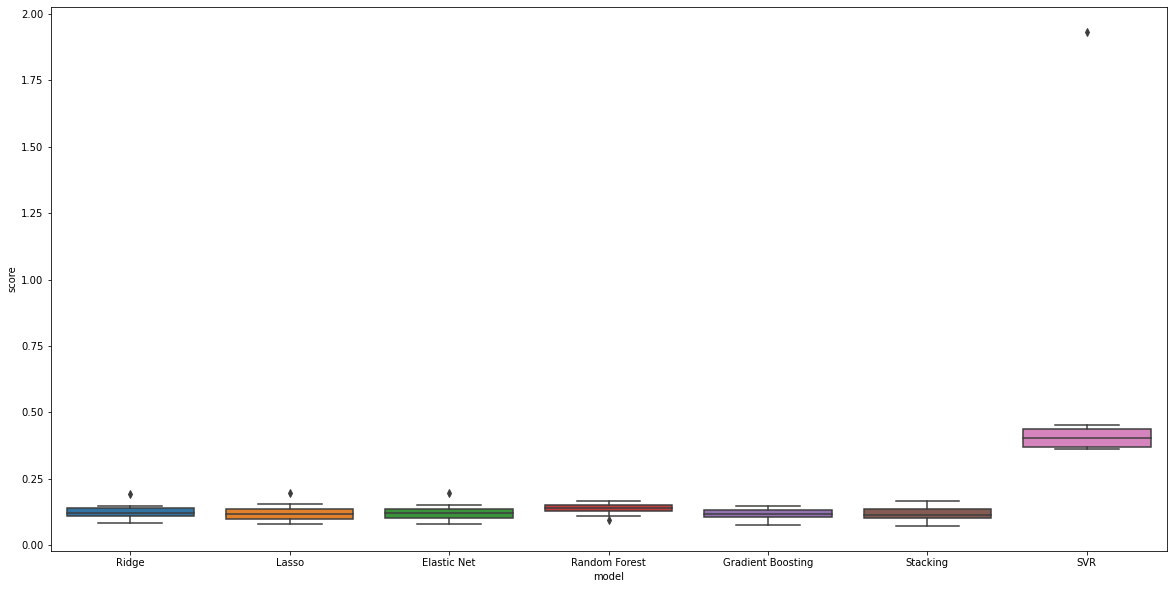

In [41]:
models = {
    'Ridge': ridge,
    'Lasso': lasso,
    'Elastic Net': elasticnet,
    'Random Forest': rf,
    'Gradient Boosting': gbr,
    'Stacking': stack, 
    'SVR': svr,
}

scores = pd.DataFrame(columns=['score', 'model'])

for name, model in models.items():
    score = cv_rmse(model)
    print("{:s} score: {:.4f} ({:.4f})\n".format(name, score.mean(), score.std()))
    df = pd.Series(score, name='score').to_frame()
    df['model'] = name
    scores = scores.append(df)

plt.figure(figsize=(20,10))
sns.boxplot(data = scores, x = 'model', y = 'score')
plt.show()

### Submission

In [42]:
print('Predict submission')
submission = pd.read_csv("../input/house-prices-advanced-regression-techniques/sample_submission.csv")

submission.iloc[:,1] = np.expm1(stack.predict(X_test))

submission.to_csv('my_submission.csv', index=False)

Predict submission


## 5. Conclusion

blah blah